In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/synonyms/synonyms-dataset.csv')

## 1.2. Statistics

In [3]:
stats = Statistics(df)

### 1.2.1. General

In [4]:
stats.general

,value
metric,
total_annotations,12906
unique_items,1985
unique_users,232
total_annotation_time,12h 40m 24s


### 1.2.2. Annotations per item

In [5]:
stats.annotations_per_item

,data__item_id
count,1985.000000
mean,6.501763
std,2.503852
min,2.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,14.000000


### 1.2.3. Annotations per user

In [6]:
stats.annotations_per_user

,user__id
count,232.000000
mean,55.629310
std,48.601129
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,450.000000


### 1.2.4. Average annotation time over time

,value
index,
10,11.483953
20,10.375833
30,11.450548
40,11.648627
60,7.486263
70,7.873434
80,4.794483
90,6.895422


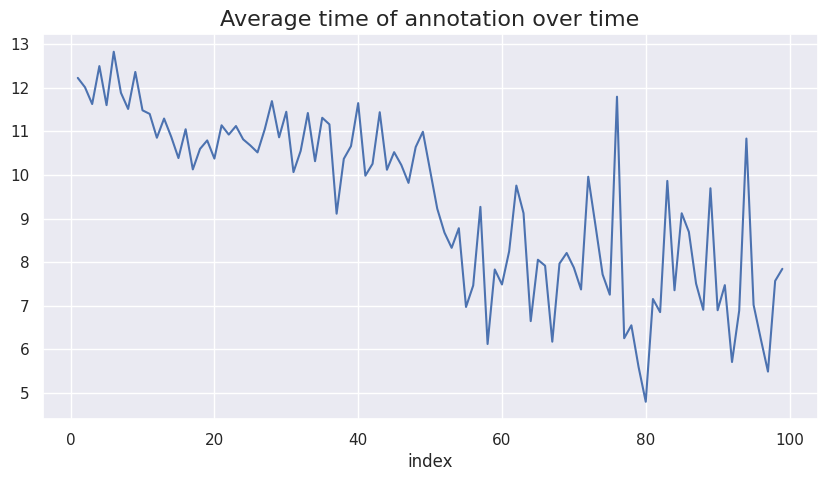

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [8]:
METRICS_COLUMNS = ["accuracy", "annotation_time", "count"]

In [9]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        "accuracy": (y_true == y_pred).mean()
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [10]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [11]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [12]:
df_ci_h1

accuracy  annotation_time      count
group_name              quantile                                      
high quality feedback   0.05     -0.005415        -0.238579  -2.527027
                        0.5       0.034901         2.003982   2.678564
                        0.95      0.074183         4.055799   9.790791
low quality feedback    0.05     -0.026337         1.111609  -6.319167
                        0.5       0.009241         3.803867   7.013690
                        0.95      0.044125         6.553108  19.411012
medium quality feedback 0.05     -0.021693        -1.991744 -45.432857
                        0.5       0.025860         1.589778 -19.207835
                        0.95      0.074581         4.959341   6.507068

#### Percentage confidence intervals

In [13]:
df_percentage_ci_h1

accuracy  annotation_time     count
group_name              quantile                                     
high quality feedback   0.05     -0.009664        -0.028819 -0.050559
                        0.5       0.062285         0.242067  0.053591
                        0.95      0.132387         0.489911  0.195888
low quality feedback    0.05     -0.052570         0.095310 -0.136262
                        0.5       0.018444         0.326145  0.151239
                        0.95      0.088076         0.561865  0.418566
medium quality feedback 0.05     -0.039276        -0.152179 -0.621025
                        0.5       0.046820         0.121467 -0.262553
                        0.95      0.135031         0.378918  0.088946

#### p-value

In [14]:
df_p_value_h1

,accuracy,annotation_time,count,group_name
0,0.9243,0.9310,0.7186,high quality feedback
0,0.6674,0.9925,0.8134,low quality feedback
0,0.8108,0.7702,0.1103,medium quality feedback


#### Cohen's D

In [15]:
df_cohen_d_h1

,accuracy,annotation_time,count,group_name
0,0.261378,0.270167,0.103388,high quality feedback
0,0.107134,0.482471,0.202538,low quality feedback
0,0.257392,0.202139,-0.342813,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

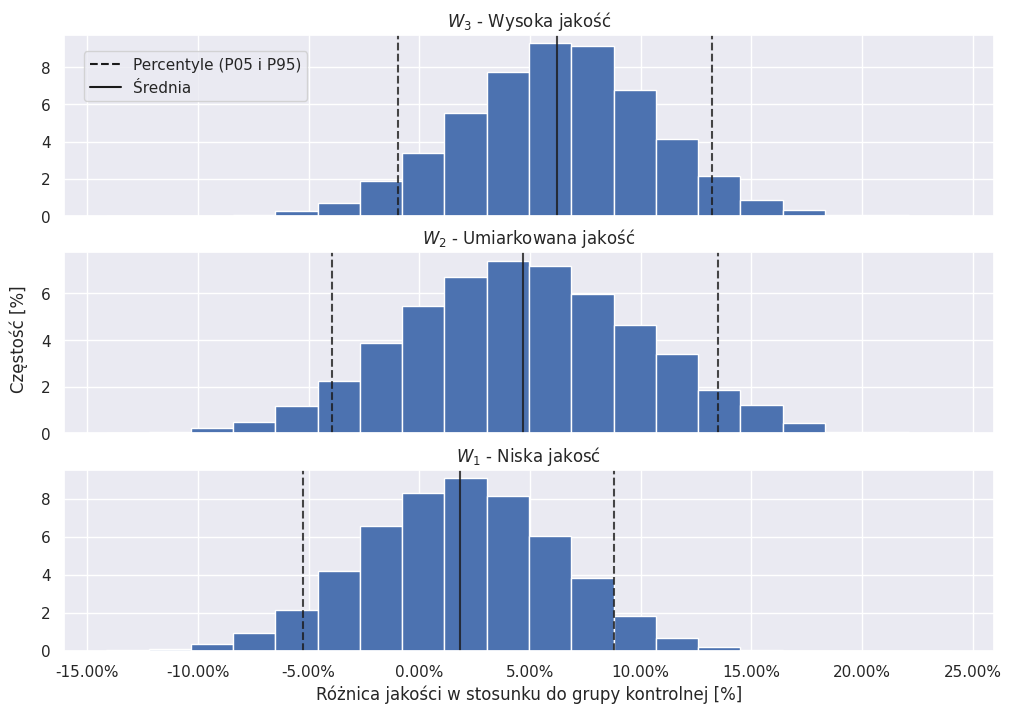

In [16]:
metric_index = 0
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [17]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [18]:
df_ci_h2

accuracy  annotation_time     count
group_name  quantile                                     
high_low    0.05     -0.057080        -0.434155 -0.418794
            0.5       0.043841        -0.084078 -0.097647
            0.95      0.139668         0.259755  0.232284
high_medium 0.05     -0.092836        -0.258567 -0.058826
            0.5       0.015465         0.120600  0.316144
            0.95      0.122018         0.516697  0.696787
medium_low  0.05     -0.072775        -0.574863 -0.868283
            0.5       0.028375        -0.204678 -0.413792
            0.95      0.142364         0.141037  0.033693

#### p-value

In [19]:
df_p_value_h2

,accuracy,annotation_time,count,group_name
0,0.7772,0.3493,0.3115,high_low
0,0.5920,0.6897,0.9203,high_medium
0,0.6541,0.1710,0.0659,medium_low


#### Cohen's D

In [20]:
df_cohen_d_h2

,accuracy,annotation_time,count,group_name
0,1.027503,-0.563562,-0.739120,high_low
0,0.322930,0.760006,1.936232,high_medium
0,0.591821,-1.349204,-2.133738,medium_low


# 3. Analyse learning curve

In [21]:
df['annotation_eval'] = (df['reference__output'] == df['annotation__output']).astype(int)
df_high = df.query("test_group == 'high quality feedback'")

In [22]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [23]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,0.006
1,$\beta$,-0.091
2,$\alpha_r$,+31.29%
3,$\beta_r$,-11.36%


#### Learning curve plot

In [24]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

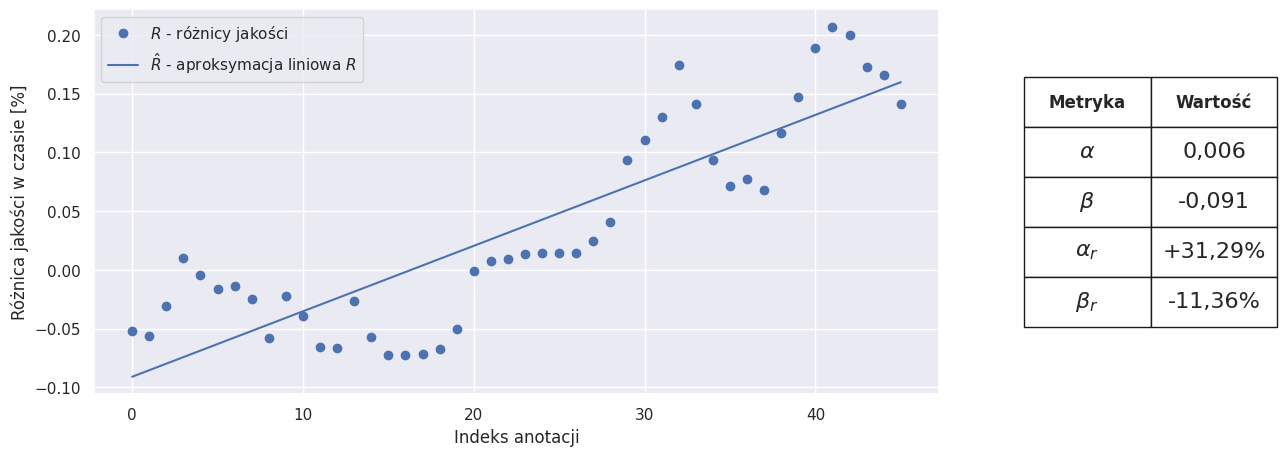

In [25]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [26]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [27]:
print(latex_generator.get_results_table("accuracy"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{-0.97\%} & \multicolumn{1}{c|}{+6.23\%} & \multicolumn{1}{c|}{+13.24\%} & \multicolumn{1}{c|}{0.9243} & 0.26 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-3.93\%} & \multicolumn{1}{c|}{+4.68\%} & \multicolumn{1}{c|}{+13.50\%} & \multicolumn{1}{c|}{0